In [1]:
"Infer pedestrian presence using PPO policy"

import argparse
from datetime import datetime
import gym
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import scipy
import PyQt5
import psutil

import ray
try:
    from ray.rllib.agents.agent import get_agent_class
except ImportError:
    from ray.rllib.agents.registry import get_agent_class
from ray.tune.registry import register_env

# from flow.algorithms.maddpg.maddpg import DEFAULT_CONFIG as MADDPG_DEFAULT_CONFIG, MADDPGTrainer

# from examples.rllib.multiagent_exps.test_predictor.pedestrian_policy_1 import create_env, create_agent
# from examples.rllib.multiagent_exps.bayesian_0_no_grid_env import make_flow_params as bayesian_1_flow_params
from examples.rllib.multiagent_exps.test_predictor.dqn_config import make_env as create_env
from examples.rllib.multiagent_exps.test_predictor.dqn_config import get_flow_params as bayesian_1_flow_params

from flow.core.util import emission_to_csv
from flow.utils.rllib import get_flow_params
from flow.utils.rllib import get_rllib_config
from flow.utils.rllib import get_rllib_pkl

from examples.rllib.multiagent_exps.test_predictor.pedestrian_policy_1 import create_agent
from get_agent import get_inference_network


EXAMPLE_USAGE = """
example usage:
    python ./visualizer_rllib.py /ray_results/experiment_dir/result_dir 1
Here the arguments are:
1 - the path to the simulation results
2 - the number of the checkpoint
"""


/home/thankyou-always/anaconda3/envs/flow3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/thankyou-always/anaconda3/envs/flow3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/thankyou-always/anaconda3/envs/flow3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/thankyou-a

In [2]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

# The Math

$$ p(c|a) = \frac{f(a|c) p(c)}{C}, C = \sum_{e \in every} f(a | e) p(e), c \text{ is some joint ped combination}$$

#### Code flow

e denotes an element within the 'every' set, where 'every' = the set of all possible pedestrian location combinations observable by a vehicle

o denotes an element with the 'other' set, where 'other' = the set of all possible pedestrian location combinations observable by a vehicle, where $o_1 = 1$ or some other specific location has a fixed value.
 
0. Fill up $p(e)$ with $\frac{1}{3^4}$

1. Fill up $f(a|e)$

2. Compute $C = \sum_{e \in every} f(a|e) p(e)$

3. Compute $p(e|a) = \frac{f(a|e) p(e)}{C}$ 

4. Update $p(e) = p(e|a)$

5. Compute $p(o_i = b_i | a) = \sum_{o \in other} p(o|a)$

6. Store $p(o_i = b_i)$

In [3]:
{0: {'00': 164579, '01': 107, '10': 107, '11': 14516}, 
 1: {'00': 163013, '01': 123, '10': 123, '11': 16050}, 
 2: {'00': 161202, '01': 134, '10': 134, '11': 17839}, 
 3: {'00': 164743, '01': 112, '10': 112, '11': 14342}}

"The keys 'ij' mean transition from state i to state j"

"The keys 'ij' mean transition from state i to state j"

p(ped_{t} | ped_{t-1}) = 14516 / (107 + 14516)

p(ped_{t} | no_ped_{t-1}) = 107 / (107 + 164579)

p(no_ped_{t} | ped_{t-1}) = 107 / (107 + 14516)

p(no_ped_{t} | no_ped_{t-1}) = 164579 / (164579 + 107)

In [4]:
pp = 14516 / (107 + 14516)
pno = 107 / (107 + 164579)
nop = 107 / (107 + 14516)
nono = 164579 / (164579 + 107)

a = np.array([nono, pno])
b = np.array([nop, pp])

TRANSITION_MATRIX = np.array([a, b])


In [5]:
# Convert constants to uppercase
K = 5
ped_idx_lst = [7, 8, 9, 10]
ped_front = ped_idx_lst[0]
ped_back = ped_idx_lst[-1]

num_locs = 4
# flag_set = ("-1", "0", "1")
flag_set = ("0", "1")

def run_env(env, agent, flow_params, is_discrete):
    """Run the simulation and control the rl car using the trained policy. 
    
    observation[4:10] = ped_param
    
    The six binary grids are at indices 4 to 9 inclusive
    """
#     # set up relevant policy and env
#     if config.get('multiagent', {}).get('policies', None):
#         multiagent = True
#         rets = {}
#         # map the agent id to its policy
#         policy_map_fn = config['multiagent']['policy_mapping_fn']
#         for key in config['multiagent']['policies'].keys():
#             rets[key] = []
#     else:
#         multiagent = False
#         rets = []
# #     import ipdb;ipdb.set_trace()
#     if config['model']['use_lstm']:
#         use_lstm = True
#         if multiagent:
#             state_init = {}
#             policy_map_fn = config['multiagent']['policy_mapping_fn']
#             size = config['model']['lstm_cell_size']
#             for key in config['multiagent']['policies'].keys():
#                 state_init[key] = [np.zeros(size, np.float32),
#                                    np.zeros(size, np.float32)]
#         else:
#             state_init = [
#                 np.zeros(config['model']['lstm_cell_size'], np.float32),
#                 np.zeros(config['model']['lstm_cell_size'], np.float32)
#             ]
#     else:
#         use_lstm = False

    env.restart_simulation(
        sim_params=flow_params['sim'], render=flow_params['sim'].render) 
    render = True
    env.should_render = render
    flow_params['sim'].render = render
    env.restart_simulation(
        sim_params=flow_params['sim'], render=render)      

    binary_observations = False
    
    # Permutation lists
    joint_ped_combos_str = all_ped_combos_strs(num_locs, flag_set)
    joint_ped_combos_int_list = all_ped_combos_lsts(num_locs, flag_set)
    single_ped_combs_str = single_ped_posteriors_strs(num_locs, flag_set)
    
    ################
    # Dictionaries #
    ################
    
    # 1
    single_priors_fixed = {comb : [1 / len(flag_set)] for comb in single_ped_combs_str} 
    single_priors_updated = {comb : [1 / len(flag_set)] for comb in single_ped_combs_str}

    # 2
    joint_likelihood_densities = {comb : [] for comb in joint_ped_combos_str}
    
    # 3
    joint_priors_fixed = {comb : [1 / (len(flag_set)**num_locs)] for comb in joint_ped_combos_str}
    joint_priors_updated = {comb : [1 / (len(flag_set)**num_locs)] for comb in joint_ped_combos_str}
    
    # 5 
    joint_posteriors_fixed = {comb : [] for comb in joint_ped_combos_str}
    joint_posteriors_updated = {comb : [] for comb in joint_ped_combos_str}
    
    # 6 
    single_posteriors_fixed = {comb : [] for comb in single_ped_combs_str}
    single_posteriors_updated = {comb : [] for comb in single_ped_combs_str}
    
    
    # 1 Filter
    single_priors_filter = {comb : [1 / len(flag_set)] for comb in single_ped_combs_str}
    
    # 3 Filter
    joint_priors_filter = {comb : [1 / (len(flag_set)**num_locs)] for comb in joint_ped_combos_str}

    # 5 Filter
    joint_posteriors_filter = {comb : [] for comb in joint_ped_combos_str}
    
    # 6 Filter
    single_posteriors_filter = {comb : [] for comb in single_ped_combs_str} 
        
    
    # 5 Updated K
    single_posteriors_updated_K = {comb : [] for comb in single_ped_combs_str}

    visible_pedestrian_dct = {loc : [] for loc in range(num_locs)}
    intersection_status = []
    
#     sigma_vals = []
#     mean_vals = []
    action_vals = []

    action_pairs = []
    
    ####################
    # Step through env #
    ####################
    
    for i in range(args.num_rollouts):
        state = env.reset()
        for time in range(600):
            vehicles = env.unwrapped.k.vehicle
            pedestrian = env.unwrapped.k.pedestrian
            multiagent = True
            if multiagent:                
                action, logits = {}, {}
                # TODO(@evinitsky) make more general
                agent_ids = ['rl_0']
                for agent_id in agent_ids:
                    use_lstm = False
                    if use_lstm:   # we don't use lstm
                        action[agent_id], state_init[agent_id], logits = \
                            agent.get_accel_gaussian_params_from_observation(state[agent_id])
                    else:
                        if state != {} and agent_id in state.keys():
                            
#                             print(psutil.virtual_memory())
                            
#                             if t > 30:
#                                 for loc_ in range(num_locs):
#                                     for val_ in flag_set:
#                                         single_posterior_str = f'o_{loc_} = {val_}'
#                                         print(len(single_priors_fixed[single_posterior_str]))
#                                         print(len(single_priors_updated[single_posterior_str]))
#                                         print(len(single_priors_filter[single_posterior_str]), 111) 
#                                         print(single_priors_filter[single_posterior_str])
#                                         print(len(single_posteriors_filter[single_posterior_str]))
#                                         print(len(single_posteriors_updated_K[single_posterior_str])) 
#                                         print(len(single_posteriors_fixed[single_posterior_str]))
#                                         print(len(single_posteriors_updated[single_posterior_str]))
#                                 for str_comb in joint_ped_combos_str:
#                                     print(len(joint_priors_filter[str_comb]))
#                                     print(len(joint_posteriors_filter[str_comb]))
#                                     print(len(joint_likelihood_densities[str_comb]))
#                                     print(len(joint_priors_fixed[str_comb]))
#                                     print(len(joint_priors_updated[str_comb]))
#                                     print(len(joint_posteriors_fixed[str_comb]))
#                                     print(len(joint_posteriors_updated[str_comb]))

                            
                            # s_all = state the agent observes
                            s_all = state[agent_id]
                            # get ped visibility state array of length 6 from the rl car's POV
                            s_ped = s_all[ped_idx_lst]

                            # update the visible_pedestrian dict
                            for idx, val in enumerate(s_ped):
                                visible_pedestrian_dct[idx] = visible_pedestrian_dct[idx] + [val]

                            # update rl car's intersection status
                            rt = vehicles.get_route('rl_0')
                            if len(rt) > 0:
                                if vehicles.get_edge('rl_0') == rt[0]:
                                    intersection_status.append(-1)
                                elif vehicles.get_edge('rl_0') == rt[-1]:
                                    intersection_status.append(1)
                                else:
                                    intersection_status.append(0)
                                             
                            # compute the actual action taken by the rl car
#                             action[agent_id], _, logit_actual = agent.compute_action(state[agent_id], policy_id=policy_map_fn(agent_id), full_fetch=True)    
                            if is_discrete:
        
                                action_index = env.k.vehicle.get_acc_controller(agent_id).get_discrete_action(env)
                            action_ = env.k.vehicle.get_acc_controller(agent_id).get_accel(env)
                            
                            # TODO(@evinitsky) don't hardcode this like this
                            if action_ is None:
                                action_ = 3.0
                            
#                             mu, ln_sigma = logit_actual['behaviour_logits']
#                             sigma = np.exp(ln_sigma)
                            
#                             sigma_vals.append(sigma)
#                             mean_vals.append(mu)
                            action_vals.append(action_)
                            
                            if action_pairs == []:
                                action_pairs.append([action_])
                            else:
                                action_pairs[-1].append(action_)
                                action_pairs.append([action_])
                                                            

                            # 2 f(a|e) # 4 M
                            M_updated, M_fixed, M_filter = 0, 0, 0
                            
                            for str_comb, lst_comb in zip(joint_ped_combos_str, joint_ped_combos_int_list):

                                s_all_modified = np.copy(s_all) # s_all_modified = hypothetical state that an agent observes
                                s_all_modified[ped_front : ped_back + 1] = lst_comb
#                                 _, _, logit = agent.compute_action(s_all_modified, policy_id=policy_map_fn(agent_id), full_fetch=True)
                                if is_discrete:
                                    _, _, logit = agent.compute_action(s_all_modified, policy_id='av', full_fetch=True)

#                                     max_index = np.argmax(logit['q_values'])
#                                     joint_likelihood_density = max_index == action_index
                                    q_vals = logit['q_values']
                                    soft_max = scipy.special.softmax(q_vals)
                                    joint_likelihood_density = soft_max[action_index]

                                else:
                                    mu, sigma = agent.get_accel_gaussian_params_from_observation(s_all_modified)
                                    sigma = sigma[0]
    #                                 mu, ln_sigma = logit['behaviour_logits']
    #                                 sigma = np.exp(ln_sigma)

                                    # f(a|e)
                                    joint_likelihood_density = accel_pdf(mu, sigma, action_)[0]
                                joint_likelihood_densities[str_comb].append(joint_likelihood_density)

                                # M
                                # Get p(e)
                                updated_prior = joint_priors_updated[str_comb][-1]
                                fixed_prior = joint_priors_fixed[str_comb][-1]
                                filtered_prior = joint_priors_filter[str_comb][-1]

                                M_updated += joint_likelihood_density * updated_prior
                                M_fixed += joint_likelihood_density * fixed_prior
                                M_filter += joint_likelihood_density * filtered_prior

                            # 5 p(e|a) joint posterior masses
                            for str_comb in joint_ped_combos_str:
                                # f(a|e)
                                joint_likelihood_density = joint_likelihood_densities[str_comb][-1]
                                # p(e)
                                updated_prior = joint_priors_updated[str_comb][-1]
                                fixed_prior = joint_priors_fixed[str_comb][-1]
                                filtered_prior = joint_priors_filter[str_comb][-1]

                                # p(e|a)
                                joint_posterior_updated = joint_likelihood_density * updated_prior / M_updated
                                joint_posterior_fixed = joint_likelihood_density * fixed_prior / M_fixed
                                joint_posterior_filtered = joint_likelihood_density * filtered_prior / M_filter

                                joint_posteriors_updated[str_comb].append(joint_posterior_updated)
                                joint_posteriors_fixed[str_comb].append(joint_posterior_fixed)
                                joint_posteriors_filter[str_comb].append(joint_posterior_filtered)

                            # 6 & 7
                            for loc_ in range(num_locs):
                                for val_ in flag_set:

                                    single_posterior_updated = 0
                                    single_posterior_fixed = 0
                                    single_posterior_filter = 0

                                    for key in ped_combos_one_loc_fixed_strs(loc_, val_):
                                        single_posterior_updated += joint_posteriors_updated[key][-1]
                                        single_posterior_fixed += joint_posteriors_fixed[key][-1]
                                        single_posterior_filter += joint_posteriors_filter[key][-1]

                                    single_posterior_str = f'o_{loc_} = {val_}'

                                    single_posteriors_updated[single_posterior_str].append(single_posterior_updated)
                                    
                                    if len(joint_priors_updated["1 1 1 1"]) < K: 
                                        single_posteriors_updated_K[single_posterior_str].append(single_posterior_updated)
                                   
                                    single_posteriors_fixed[single_posterior_str].append(single_posterior_fixed)
                                    single_posteriors_filter[single_posterior_str].append(single_posterior_filter)
                                    
                                    # 7
                                    single_priors_fixed[single_posterior_str].append(single_posterior_fixed)
                                    single_priors_updated[single_posterior_str].append(single_posterior_updated)
                                    
                            # FILTER (part after step 6: filter p(o|a))
                            for loc_ in range(num_locs):
                                val0, val1 = "0", "1"
                                single_0 = f'o_{loc_} = {val0}'
                                single_1 = f'o_{loc_} = {val1}'
                                try:
                                    filtered = TRANSITION_MATRIX @ np.array([single_posteriors_filter[single_0][-1], single_posteriors_filter[single_1][-1]])
                                except:
                                    import ipdb; ipdb.set_trace()
                                single_posteriors_filter[single_0][-1], single_posteriors_filter[single_1][-1] = filtered[0], filtered[1]

                           # 7 Filter Update single priors Pr(o_i | a) using posteriors
                            for loc_ in range(num_locs):
                                for val_ in flag_set:
                                    single_prior_str = f'o_{loc_} = {val_}'
                                    single_priors_filter[single_prior_str].append(single_posteriors_filter[single_prior_str][-1])

                            # 8 Update joint priors p(o|a) = \prod_{o_i \in o} p(o_i)
                            for str_comb in joint_ped_combos_str:
                                new_joint_prior_updated = 1
                                new_joint_prior_fixed = 1

                                single_ped_lst = joint_ped_combo_str_to_single_ped_combo(str_comb)
                                for single_ped in single_ped_lst:
                                    new_joint_prior_updated *= single_posteriors_updated[single_ped][-1]

                                joint_priors_updated[str_comb].append(new_joint_prior_updated)

                            # 8 FILTER Update joint priors p(o|a) = \prod_{o_i \in o} p(o_i)
                            for str_comb in joint_ped_combos_str:
                                new_joint_prior_filter = 1

                                single_ped_lst = joint_ped_combo_str_to_single_ped_combo(str_comb)

                                for single_ped in single_ped_lst:
                                    new_joint_prior_filter *= single_priors_filter[single_ped][-1]

                                joint_priors_filter[str_comb].append(new_joint_prior_filter)
    
    
                            ############            
                            # K update #
                            ############
                
                            if len(joint_likelihood_densities["1 1 1 1"]) >= K:
                                joint_priors_updated_K = {comb : [1 / (len(flag_set)**num_locs)] for comb in joint_ped_combos_str}

                                for str_comb, lst_comb in zip(joint_ped_combos_str, joint_ped_combos_int_list):

                                    s_all_modified = np.copy(s_all) # s_all_modified = hypothetical state that an agent observes
                                    s_all_modified[ped_front : ped_back + 1] = lst_comb
# #                                     _, _, logit = agent.compute_action(s_all_modified, policy_id=policy_map_fn(agent_id), full_fetch=True)

#                                     mu, ln_sigma = logit['behaviour_logits']
#                                     sigma = np.exp(ln_sigma)
                                if not is_discrete:
                                    mu, sigma = agent.get_accel_gaussian_params_from_observation(s_all_modified)
                                    sigma = sigma[0]

                                # update joint prior masses
                                for i in reversed(range(K)):
                                    M_updated_K = 0
                                    for str_comb in joint_ped_combos_str:
                                        M_updated_K += joint_likelihood_densities[str_comb][-1 - i] * joint_priors_updated_K[str_comb][-1]
                                    for str_comb in joint_ped_combos_str:
                                        joint_likelihood_density = joint_likelihood_densities[str_comb][-1 - i] # f(a|c)
                                        joint_prior_updated = joint_priors_updated_K[str_comb][-1] # p(c)
                
                                        joint_priors_updated_K[str_comb].append(joint_likelihood_density * joint_prior_updated / M_updated_K)
                                    
                                # 5 Compute single posteriors Pr(o_i = b_i | a)
                                for loc__ in range(num_locs):
                                    for val__ in flag_set:

                                        single_posterior_updated = 0

                                        for key in ped_combos_one_loc_fixed_strs(loc__, val__):
                                            single_posterior_updated += joint_priors_updated_K[key][-1]

                                        single_posterior_str = f'o_{loc__} = {val__}'
                                        single_posteriors_updated_K[single_posterior_str].append(single_posterior_updated)

            else:
                action = agent.compute_action(state)

            state, reward, done, _ = env.step(None)

            if multiagent and done['__all__']:
                break
            if not multiagent and done:

                break    
#             state, reward, done, _ = env.step(action)   

    visible_ped_lsts = [visible_pedestrian_dct[i] for i in range(num_locs)]
    legends = [f'ped at loc {i}' for i in range(num_locs)]

    
    for loc in range(num_locs):
        for val in [0, 1]:
            single_posterior_str = single_posterior_to_str(loc, val)
            a_ = single_posteriors_updated[single_posterior_str]
            b_ = single_posteriors_fixed[single_posterior_str]
            c_ = single_posteriors_updated_K[single_posterior_str]
            d_ = single_posteriors_filter[single_posterior_str]
            plot_2_lines(a_, b_, [f'Pr(ped in grid {loc} = {val}) using updated priors K = all', f'Pr(ped in grid {loc} = {val}) using fixed priors'])
            plot_2_lines(c_, b_, [f'Pr(ped in grid {loc} = {val}) using updated priors K = 5', f'Pr(ped in grid {loc} = {val}) using fixed priors'])
            plot_2_lines(d_, b_, [f'Pr(ped in grid {loc} = {val}) using filtered priors', f'Pr(ped in grid {loc} = {val}) using fixed priors'])

    fig = plt.figure(figsize=(15, 15))
    y0 = visible_pedestrian_dct[0]
    y1 = visible_pedestrian_dct[1]
    y2 = visible_pedestrian_dct[2]
    y3 = visible_pedestrian_dct[3]

    vis_ped_0 = plt.subplot(2, 4, 1)
    plt.plot(y0, 'o-')
    vis_ped_0.set_title('Pedestrian in loc 0')
    vis_ped_0.set_xlabel('time (s)')
    vis_ped_0.set_ylabel('in loc 1?')
    vis_ped_0.set_ylim([-1, 1])

    vis_ped_1 = plt.subplot(2, 4, 2)
    plt.plot(y1, 'o-')
    vis_ped_1.set_title('Pedestrian in loc 1')
    vis_ped_1.set_xlabel('time (s)')
    vis_ped_1.set_ylabel('in loc 1?')
    vis_ped_1.set_ylim([-1, 1])

    vis_ped_2 = plt.subplot(2, 4, 3)
    vis_ped_2.plot(y2, '.-')
    vis_ped_2.set_title('Pedestrian in loc 2')

    vis_ped_2.set_xlabel('time (s)')
    vis_ped_2.set_ylabel('in loc 2?')
    vis_ped_2.set_ylim([-1, 1])


    vis_ped_3 = plt.subplot(2, 4, 4)
    vis_ped_3.plot(y3, '.-')
    vis_ped_3.set_title('Pedestrian in loc 3')

    vis_ped_3.set_xlabel('time (s)')
    vis_ped_3.set_ylabel('in loc 3?')
    vis_ped_3.set_ylim([-1, 1])

    print(intersection_status, len(intersection_status))
    intersection = plt.subplot(2, 4, 5)
    intersection.plot(intersection_status)
    intersection.set_title('-1 = approaching, 0 = on intersection, 1 = past')
    intersection.set_xlabel('time (s)')
    intersection.set_ylabel('rl car location')
    intersection.set_ylim([-1, 1])
    
#     sigma = plt.subplot(2, 4, 6)
#     sigma.plot(sigma_vals)
#     sigma.set_title('Sigma')
#     sigma.set_xlabel('time (s)')
#     sigma.set_ylabel('sigma')
    
#     mean = plt.subplot(2, 4, 7)
#     mean.plot(mean_vals)
#     mean.set_title('Mean')
#     mean.set_xlabel('time (s)')
#     mean.set_ylabel('mean')
    
    x = np.array(action_vals)
    x1 = x[1:]
    x2 = x[:-1]
    xx = np.stack([x1, x2])
    print(np.cov(xx))
    return x1, x2

# String and permutation helper functions

In [6]:
def joint_ped_combo_str_to_single_ped_combo(joint_ped_combo_str):
    """Given a string of format '0 1 0 -1', return a list of all relevant single ped strings
    i.e ['o_0 = 0', 'o_1 = 1', 'o_2 = 0', 'o_3 = -1']
    """
    res = []
    jnt_ped_list = joint_ped_combo_str.split(" ")
    for loc, val in enumerate(jnt_ped_list):
        res.append(single_posterior_to_str(loc, val))
    return res

def single_posterior_to_str(loc, val):
    return f'o_{loc} = {val}'

def all_ped_combos_strs(num_locs=4, val_set=("0", "1")):
    """Return a list of all pedestrian observation combinations (in string format) for a vehicle under the 4 location scheme"""
    res = []
    lsts = all_ped_combos_lsts(num_locs, val_set)
    for lst in lsts:
        res.append(" ".join(lst))
    return res

def all_ped_combos_lsts(num_locs=4, val_set=("0", "1")):
    """Return a list of all pedestrian observation combinations (in list format) for a vehicle under the 4 location scheme"""
    res = []
    if num_locs == 0:
        return []
    if num_locs == 1:
        return [[flag] for flag in val_set]

    for comb in all_ped_combos_lsts(num_locs - 1, val_set):
        # append a flag for all possible flags
        for flag in val_set:
            appended = comb + [flag]
            res.append(appended)
            
    return res

def ped_combos_one_loc_fixed_strs(fixed_loc, fixed_val, num_locs=4, val_set=("0", "1")):
    """Return a list of all ped observation combs for a vehicle under the 4 location scheme
    SUBJECT TO fixed_loc == fix_val
    
    This is handy for summation selection in equation (4) of the derivation
    
    @Parameters
    fixed_loc: int
        location from 0, 1, 2, 3
    fixed_val: int
        location from -1, 0, 1
    """    
    res = []
    lsts = ped_combos_one_loc_fixed_lsts(fixed_loc, fixed_val, num_locs, val_set)
    for lst in lsts:
        res.append(" ".join(lst))
    return res

def ped_combos_one_loc_fixed_lsts(fixed_loc, fixed_val, num_locs=4, val_set=("0", "1")):
    """Return a list of all ped observation combs for a vehicle under the 4 location scheme
    SUBJECT TO fixed_loc == fix_val
    
    This is handy for summation selection in equation (4) of the derivation
    
    @Parameters
    fixed_loc: int
        location from 0, 1, 2, 3
    fixed_val: int
        location from -1, 0, 1
    """
    fixed_val = str(fixed_val)
    assert fixed_loc < num_locs and (fixed_val in val_set or str(fixed_val) in val_set)
    
    res = []
    for comb in all_ped_combos_lsts(num_locs - 1, val_set):
        # insert fixed val at correct position
        left = comb[:fixed_loc]
        right = comb[fixed_loc:]
        res.append(left + [fixed_val] + right)
    
    return res

def single_cond_prob_to_str(grid_idx, val, num_indices = 6):
    """Generate the string representing the probability:
    
    Pr(o_i = val)
    
    ex:
    For Pr(o_2 = 1), we'd have the string '21'
    NB we're 1-indexing here
    """
    assert grid_idx >= 1 and grid_idx <= num_indices
    return str(grid_idx) + str(val)

# better name for this? 
def ped_combos_for_single_cond_prob(grid_idx, val, output_len=6):
    """Helper function for computing a 'single' conditional probability e.g. p(o_3 = 1 | action)
    Returns a list of pedestrian combinations to sum over to get the single conditional probability.
    
    Params
    ------
    grid_idx: int from 1 to 6 representing the grid cell we're considering
    val: 0 or 1: 0 means no ped in the grid; 1 means ped in the grid
    
    3:0 means we want p(o_3 = 0 | a)
    Therefore, we can get the list of all possible length 5 bitstrings, and stitch '0' in the correct place.
    
    
    Returns
    -------
    list of bit strings of length 6
    """
    
    assert grid_idx >= 1 and grid_idx <= output_len
    res = []
    res_lst = make_permutations(output_len - 1, 2)
    
    for perm in res_lst:
        res.append(str(perm[:grid_idx - 1:] + str(val) + perm[grid_idx - 1:]))
        
    return res

def initial_prior_probs(num_digits=4, vals_per_dig=2):
    """Returns a dict with values of all permutations of bitstrings of length num_digits. 
    Each digit can take a value from 0 to (vals_per_dig - 1)"""
    uniform_prob = 1 / (vals_per_dig ** num_digits)
    res = make_dct_of_lsts(num_digits, vals_per_dig)
    for key in res.keys():
        res[key] = res[key] + [uniform_prob]
    return res

def make_dct_of_lsts(num_digits=4, vals_per_dig=2):
    """Return a dict with keys of bitstrings and values as empty lists. 
    Hardcoded for binary vals per var."""
    res = {}
    lst_of_bitstrings = make_permutations(num_digits, vals_per_dig)
        
    return {str_ : [] for str_ in lst_of_bitstrings}

def make_permutations(num_digits, vals_per_dig=2):
    """Make all permutations for a bit string of length num_digits
    and vals_per_dig values per digit. Hardcoded for work for binary vals per var"""
    if num_digits == 1:
        return [str(i) for i in range(vals_per_dig)]
    else:
        small_perms = make_permutations(num_digits - 1, vals_per_dig)
        # hardcoded for work for binary vals per var
        return ['0' + bit_str for bit_str in small_perms] + ['1' + bit_str for bit_str in small_perms]
    
def single_ped_posteriors_strs(num_variables=4, val_set=("0", "1")):
    """
    @Params
    num_variables = number of ped locations
    
    @Returns
    list of strings. Strings have the format: 'o_{i}={val}', where val is in val_set
    """
    res = []
    for i in range(num_variables):
        for flag in val_set:
            res.append(f'o_{i} = {flag}')
    return res

## Other helper functions

In [7]:
def accel_pdf(mu, sigma, actual):
    """Return pdf evaluated at actual acceleration"""
    coeff = 1 / np.sqrt(2 * np.pi * (sigma**2))
    exp = -0.5 * ((actual - mu) / sigma)**2
    return coeff * np.exp(exp)

def run_transfer(args, action_pairs_lst=[], imitation_model=True, is_discrete=False):
    """To run inference using the imitation model, set imitation_model True, is_discrete False.
    To run DQN inference, set imitation_model = False, is_discrete = True"""
    # run transfer on the bayesian 1 env first
    action_pairs_lst = []
    bayesian_0_params = bayesian_1_flow_params(args, pedestrians=True, render=False)
    env, env_name = create_env(args, bayesian_0_params)
    if imitation_model:
        agent = get_inference_network(os.path.abspath("../flow/controllers/imitation_learning/model_files/c_test.h5"), flow_params=bayesian_0_params)
    else:
        agent, config = create_agent(args, flow_params=bayesian_0_params)
    action_pairs_lst = run_env(env, agent, bayesian_0_params, is_discrete)
    
    return action_pairs_lst
def plot_2_lines(y1, y2, legend, viewable_ped=False):
    x = np.arange(len(y1))
    plt.plot(x, y1)
    plt.plot(x, y2)
    if viewable_ped:
        plt.plot(x, viewable_ped)
    plt.legend(legend, bbox_to_anchor=(0.5, 1.05), loc=3, borderaxespad=0.)
    plt.ylim(-0.1, 1.1)

    plt.draw()
    plt.pause(0.001)
    
def plot_lines(y_val_lsts, legends):
    assert len(y_val_lsts) == len(legends)
    x = np.arange(len(y_val_lsts[0]))
    for y_vals in y_val_lsts:
        plt.plot(x, y_vals)
    plt.ylim(-0.1, 1.1)

    plt.legend(legends, bbox_to_anchor=(0.5, 1.05), loc=3, borderaxespad=0.)
    plt.draw()
    plt.pause(0.001)
    
def create_parser():
    """Create the parser to capture CLI arguments."""
    parser = argparse.ArgumentParser(
        formatter_class=argparse.RawDescriptionHelpFormatter,
        description='[Flow] Evaluates a reinforcement learning agent '
                    'given a checkpoint.',
        epilog=EXAMPLE_USAGE)

    # required input parameters
    parser.add_argument(
        'result_dir', type=str, help='Directory containing results')
    parser.add_argument('checkpoint_num', type=str, help='Checkpoint number.')

    # optional input parameters
    parser.add_argument(
        '--run',
        type=str,
        help='The algorithm or model to train. This may refer to '
             'the name of a built-on algorithm (e.g. RLLib\'s DQN '
             'or PPO), or a user-defined trainable function or '
             'class registered in the tune registry. '
             'Required for results trained with flow-0.2.0 and before.')
    parser.add_argument(
        '--num_rollouts',
        type=int,
        default=1,
        help='The number of rollouts to visualize.')
    parser.add_argument(
        '--gen_emission',
        action='store_true',
        help='Specifies whether to generate an emission file from the '
             'simulation')
    parser.add_argument(
        '--evaluate',
        action='store_true',
        help='Specifies whether to use the \'evaluate\' reward '
             'for the environment.')
    parser.add_argument(
        '--render_mode',
        type=str,
        default='sumo_gui',
        help='Pick the render mode. Options include sumo_web3d, '
             'rgbd and sumo_gui')
    parser.add_argument(
        '--save_render',
        action='store_true',
        help='Saves a rendered video to a file. NOTE: Overrides render_mode '
             'with pyglet rendering.')
    parser.add_argument(
        '--horizon',
        type=int,
        help='Specifies the horizon.')
    parser.add_argument(
        "--randomize_vehicles", default=True,
        help="randomize the number of vehicles in the system and where they come from",
        action="store_true")
    
    parser.add_argument('--grid_search', action='store_true', default=False,
                        help='If true, a grid search is run')
    parser.add_argument('--run_mode', type=str, default='local',
                        help="Experiment run mode (local | cluster)")
    parser.add_argument('--algo', type=str, default='TD3',
                        help="RL method to use (PPO, TD3, MADDPG)")
    parser.add_argument("--pedestrians",
                        help="use pedestrians, sidewalks, and crossings in the simulation",
                        action="store_true")
    
    return parser

In [8]:
parser = create_parser()
args = parser.parse_args([os.path.expanduser("~/ray_results/final_policy_rss/DQN_0_0_2020-06-24_14-19-463mwnbpq0"), "400"])
ray.shutdown()
ray.init(num_cpus=1)



2020-06-25 20:21:51,942	INFO resource_spec.py:212 -- Starting Ray with 6.59 GiB memory available for workers and up to 3.31 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-06-25 20:21:52,362	INFO services.py:1170 -- View the Ray dashboard at localhost:8266


{'node_ip_address': '192.168.1.242',
 'raylet_ip_address': '192.168.1.242',
 'redis_address': '192.168.1.242:51856',
 'object_store_address': '/tmp/ray/session_2020-06-25_20-21-51_941349_32477/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-06-25_20-21-51_941349_32477/sockets/raylet',
 'webui_url': 'localhost:8266',
 'session_dir': '/tmp/ray/session_2020-06-25_20-21-51_941349_32477'}

(2.1)--(1.1) (1.1)--(1.2) 1 1
(2.1)--(1.1) (1.1)--(1.2) 1 1
True


2020-06-25 20:21:55,764	INFO trainer.py:421 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-06-25 20:21:55,782	WARNING deprecation.py:30 -- DeprecationWarning: `callbacks dict interface` has been deprecated. Use `a class extending rllib.agents.callbacks.DefaultCallbacks` instead. This will raise an error in the future!
2020-06-25 20:21:55,782	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-06-25 20:21:55,797	WARNING deprecation.py:30 -- DeprecationWarning: `callbacks dict interface` has been deprecated. Use `a class extending rllib.agents.callbacks.DefaultCallbacks` instead. This will raise an error in the future!


(2.1)--(1.1) (1.1)--(1.2) 1 1
False


2020-06-25 20:21:58,272	WARNING trainer_template.py:124 -- The experimental distributed execution API is enabled for this algorithm. Disable this by setting 'use_exec_api': False.
2020-06-25 20:21:58,273	INFO trainable.py:217 -- Getting current IP.
2020-06-25 20:21:58,274	WARNING util.py:37 -- Install gputil for GPU system monitoring.
2020-06-25 20:21:58,354	INFO trainable.py:217 -- Getting current IP.
2020-06-25 20:21:58,354	INFO trainable.py:423 -- Restored on 192.168.1.242 from checkpoint: /home/thankyou-always/ray_results/final_policy_rss/DQN_0_0_2020-06-24_14-19-463mwnbpq0/checkpoint_400/checkpoint-400
2020-06-25 20:21:58,355	INFO trainable.py:430 -- Current state after restoring: {'_iteration': 400, '_timesteps_total': None, '_time_total': 5144.111568212509, '_episodes_total': 1059}
2020-06-25 20:22:19,823	WARNING deprecation.py:30 -- DeprecationWarning: `callbacks dict interface` has been deprecated. Use `a class extending rllib.agents.callbacks.DefaultCallbacks` instead. This w

(2.1)--(1.1) (1.1)--(1.2) 1 1
False


2020-06-25 20:22:22,356	WARNING trainer_template.py:124 -- The experimental distributed execution API is enabled for this algorithm. Disable this by setting 'use_exec_api': False.
2020-06-25 20:22:22,358	INFO trainable.py:217 -- Getting current IP.
2020-06-25 20:22:22,358	WARNING util.py:37 -- Install gputil for GPU system monitoring.
2020-06-25 20:22:22,442	INFO trainable.py:217 -- Getting current IP.
2020-06-25 20:22:22,443	INFO trainable.py:423 -- Restored on 192.168.1.242 from checkpoint: /home/thankyou-always/ray_results/final_policy_rss/DQN_0_0_2020-06-24_14-19-463mwnbpq0/checkpoint_400/checkpoint-400
2020-06-25 20:22:22,443	INFO trainable.py:430 -- Current state after restoring: {'_iteration': 400, '_timesteps_total': None, '_time_total': 5144.111568212509, '_episodes_total': 1059}
2020-06-25 20:22:22,453	WARNING deprecation.py:30 -- DeprecationWarning: `callbacks dict interface` has been deprecated. Use `a class extending rllib.agents.callbacks.DefaultCallbacks` instead. This w

(2.1)--(1.1) (1.1)--(1.2) 1 1
Error making env  Cannot re-register id: Bayesian0NoGridEnv-v10
False


2020-06-25 20:22:25,038	WARNING trainer_template.py:124 -- The experimental distributed execution API is enabled for this algorithm. Disable this by setting 'use_exec_api': False.
2020-06-25 20:22:25,039	INFO trainable.py:217 -- Getting current IP.
2020-06-25 20:22:25,040	WARNING util.py:37 -- Install gputil for GPU system monitoring.
2020-06-25 20:22:25,118	INFO trainable.py:217 -- Getting current IP.
2020-06-25 20:22:25,119	INFO trainable.py:423 -- Restored on 192.168.1.242 from checkpoint: /home/thankyou-always/ray_results/final_policy_rss/DQN_0_0_2020-06-24_14-19-463mwnbpq0/checkpoint_400/checkpoint-400
2020-06-25 20:22:25,119	INFO trainable.py:430 -- Current state after restoring: {'_iteration': 400, '_timesteps_total': None, '_time_total': 5144.111568212509, '_episodes_total': 1059}
2020-06-25 20:22:25,134	WARNING deprecation.py:30 -- DeprecationWarning: `callbacks dict interface` has been deprecated. Use `a class extending rllib.agents.callbacks.DefaultCallbacks` instead. This w

(2.1)--(1.1) (1.1)--(1.2) 1 1
Error making env  Cannot re-register id: Bayesian0NoGridEnv-v10
False


2020-06-25 20:22:27,761	WARNING trainer_template.py:124 -- The experimental distributed execution API is enabled for this algorithm. Disable this by setting 'use_exec_api': False.
2020-06-25 20:22:27,762	INFO trainable.py:217 -- Getting current IP.
2020-06-25 20:22:27,763	WARNING util.py:37 -- Install gputil for GPU system monitoring.
2020-06-25 20:22:27,857	INFO trainable.py:217 -- Getting current IP.
2020-06-25 20:22:27,858	INFO trainable.py:423 -- Restored on 192.168.1.242 from checkpoint: /home/thankyou-always/ray_results/final_policy_rss/DQN_0_0_2020-06-24_14-19-463mwnbpq0/checkpoint_400/checkpoint-400
2020-06-25 20:22:27,858	INFO trainable.py:430 -- Current state after restoring: {'_iteration': 400, '_timesteps_total': None, '_time_total': 5144.111568212509, '_episodes_total': 1059}


action is  4
action is  3
action is  8
action is  1
action is  8
action is  8
action is  2
action is  9
action is  2
action is  7
action is  9
action is  7
action is  2
action is  7
action is  3
action is  4
action is  2
action is  0
action is  8
action is  4
action is  2
action is  6
action is  3
action is  5
action is  7
action is  3
action is  1
action is  8
action is  3
action is  8
action is  3
action is  3
action is  8
action is  5


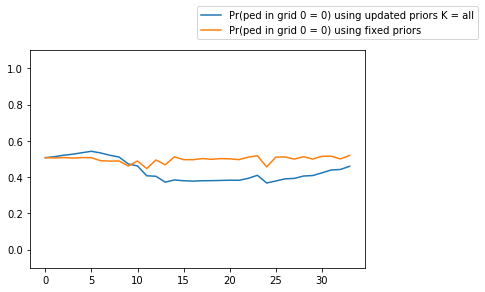

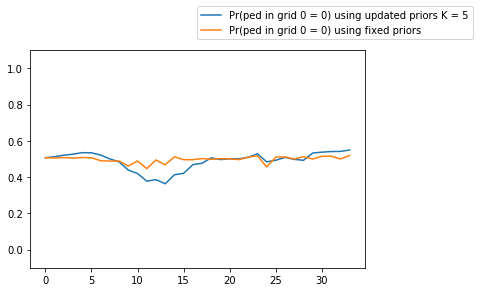

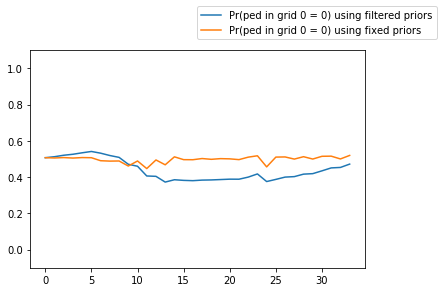

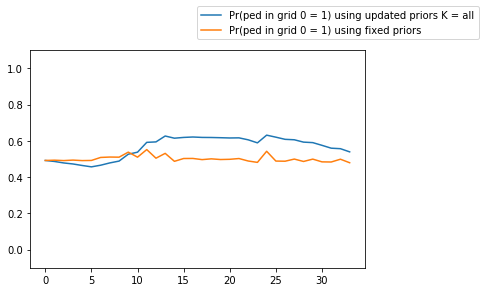

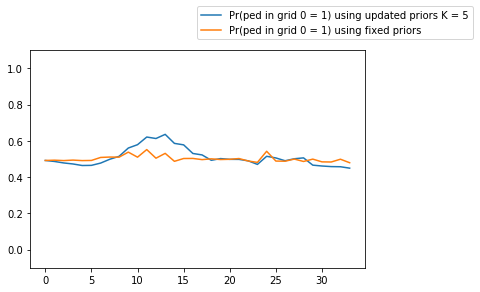

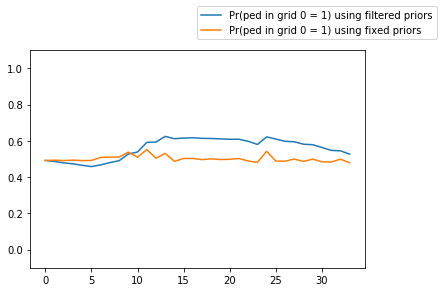

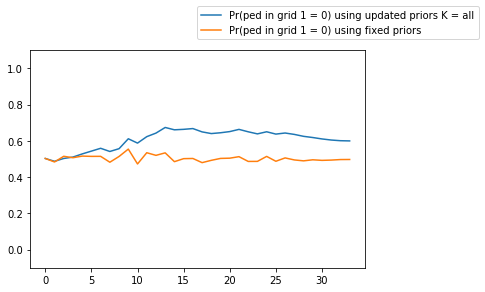

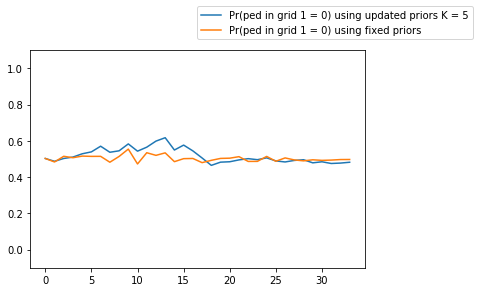

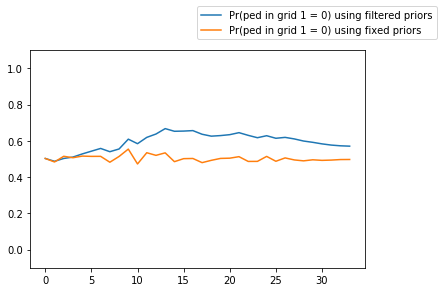

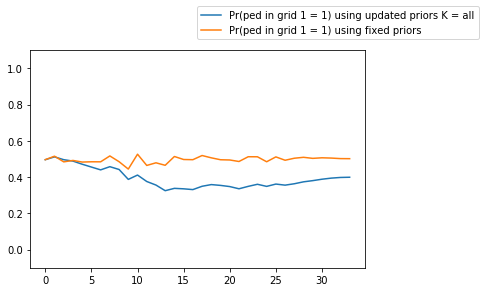

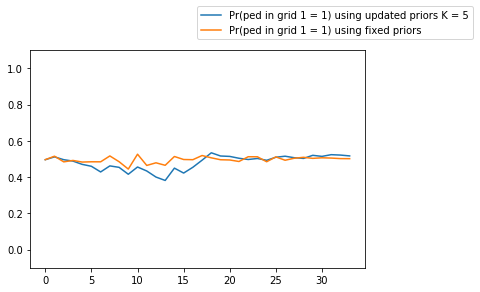

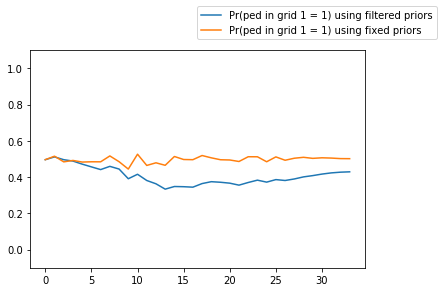

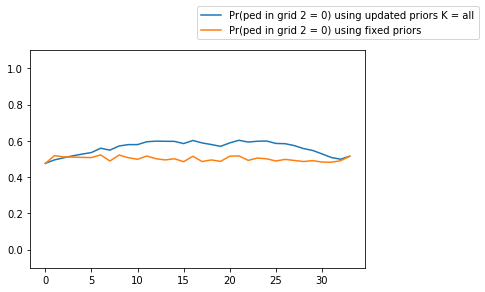

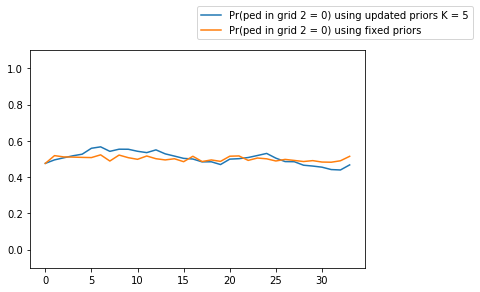

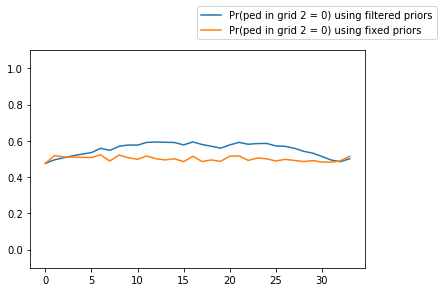

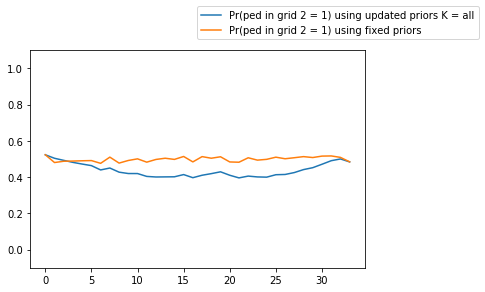

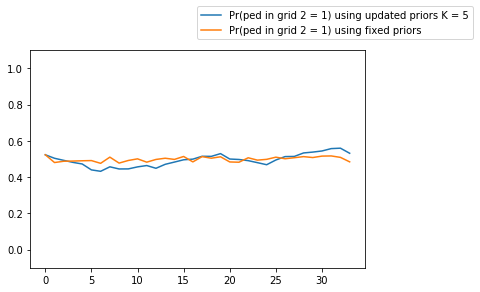

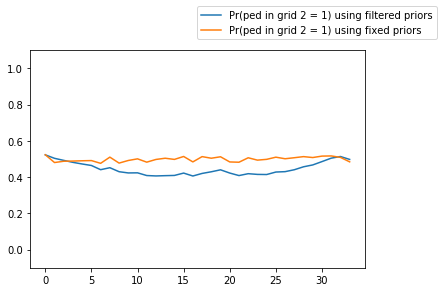

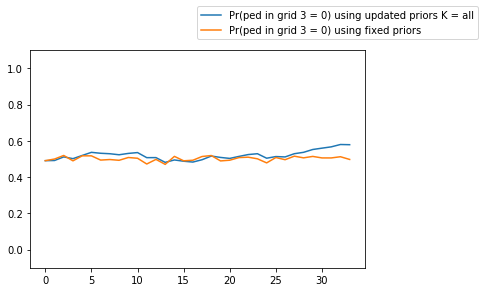

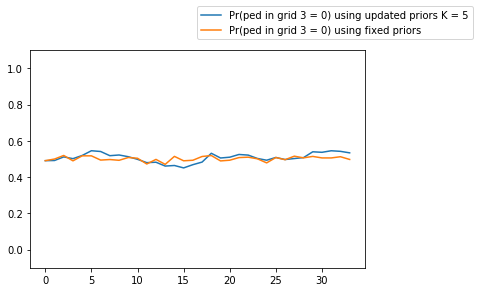

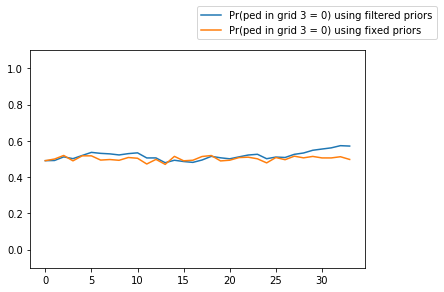

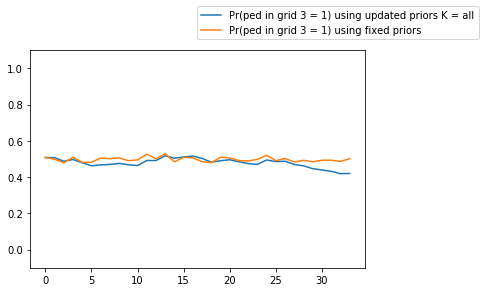

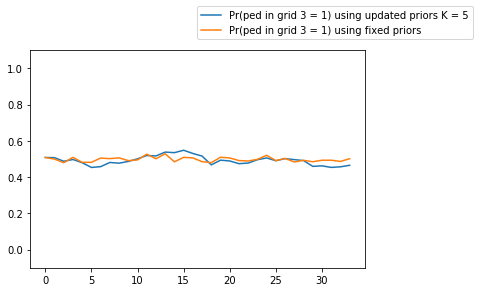

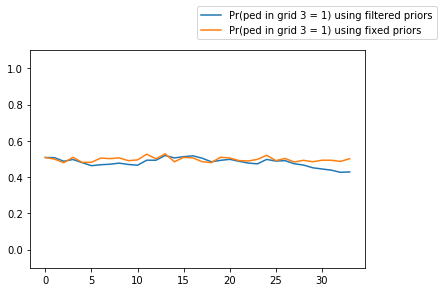

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 34
[[1.43 0.77]
 [0.77 1.20]]


(array([2.05, 2.05, 2.05, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, -2.86, -2.86,
        -0.41, 0.41, 0.41, 0.41, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23,
        1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, -2.05]),
 array([2.05, 2.05, 2.05, 2.05, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, -2.86,
        -2.86, -0.41, 0.41, 0.41, 0.41, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23,
        1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23]))

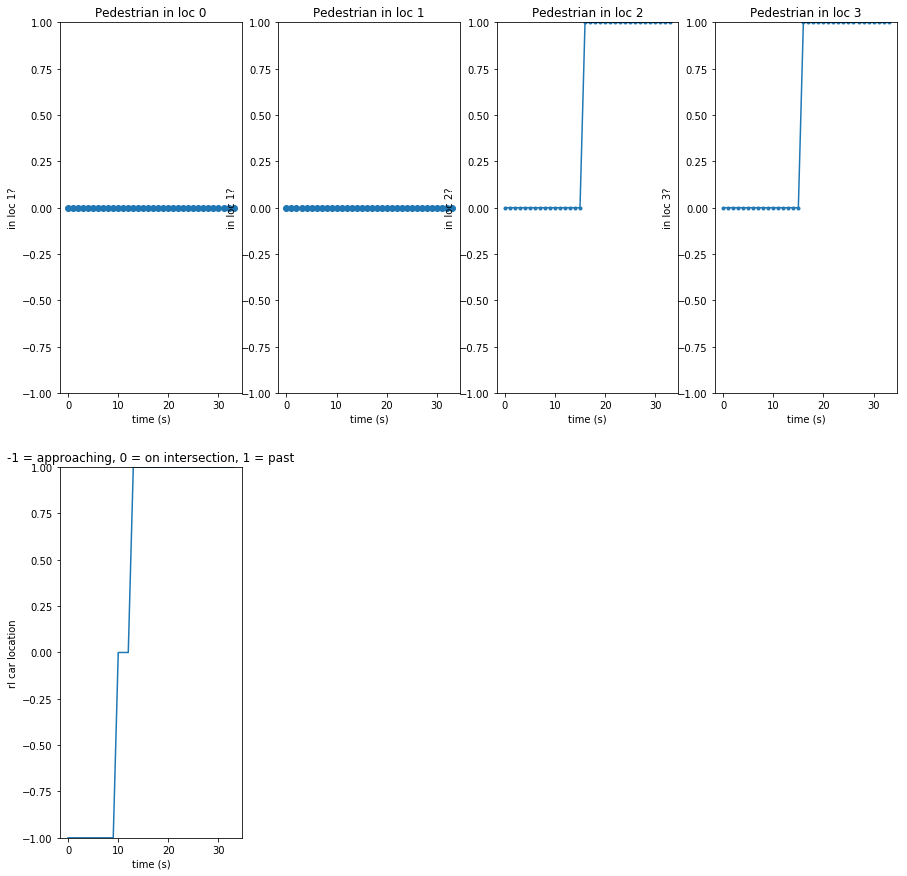

In [9]:
run_transfer(args, imitation_model=False, is_discrete=True)

In [ ]:
action_pair_vals = [[], []]

for _ in range(3):
    vals = list(run_transfer(args))
    action_pair_vals[0].extend(vals[0])
    action_pair_vals[1].extend(vals[1])
    print(action_pair_vals)
    
action_pair_vals = np.array(action_pair_vals)

In [ ]:
xx = np.stack([action_pair_vals[0], action_pair_vals[1]])
np.cov(xx)

In [ ]:
action_pair_vals.shape

In [ ]:
np.cov(action_pair_vals)

In [ ]:
a.shape

In [ ]:
c = [[2.6, 2.6], [2.6, -0.1363802], [-0.1363802, 2.6], [2.6, -2.239944], [-2.239944, 0.11161637], [0.11161637, -4.5], [-4.5, -4.5], [-4.5, -4.190493], [-4.190493, -4.5], [-4.5, 0.22552395], [0.22552395, -4.5], [-4.5, -4.5], [-4.5, -4.5], [-4.5, -4.5], [-4.5, -4.5], [-4.5, -4.5], [-4.5, -4.5], [-4.5, -4.5], [-4.5, -4.5], [-4.5, -4.5], [-4.5, 2.1391077], [2.1391077, -4.5], [-4.5, -4.5], [-4.5, -4.5], [-4.5, -4.5], [-4.5, -4.5], [-4.5, -4.5], [-4.5, -4.5], [-4.5, -4.5], [-4.5]]

In [ ]:
b